In [6]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '.30'

import jax.numpy as jnp
import jax
import pickle

jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_platform_name", "cpu")

os.chdir('/home/zongchen/drmmd/')

import matplotlib.pyplot as plt
from matplotlib import cm
import math

plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 18
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')
plt.tight_layout()

plt.rc('font', size=18)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=16, frameon=False)
plt.rc('xtick', labelsize=12, direction='in')
plt.rc('ytick', labelsize=12, direction='in')
plt.rc('figure', figsize=(6, 4))

cmap = cm.get_cmap('tab10')
color_dict = {'chard': 'red', 'mmd': 'steelblue', 'kale': 'forestgreen'}
alpha = 0.1

from kwgflows.rkhs.kernels import *
import ot
from kwgflows.divergences.mmd import *


/tmp/ipykernel_77752/3074942626.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10')


<Figure size 600x400 with 0 Axes>

In [7]:
def check_items_in_filename(filename, items):
    results = {}
    for item in items:
        results[item] = item in filename
    return results

trajectorys = {'mmd': None,
               'chard': None,
               'kale': None,}

configs = {'mmd': None,
              'chard': None,
              'kale': None,}

labels = {'mmd': r'$\text{MMD}^2(\cdot | \pi)$',
          'chard': r'$\text{DrMMD}(\cdot | \pi)$',
          'wass': r'$W_2(\cdot | \pi)$'}

In [8]:
def generate_three_ring_and_gaussian(Nx, Ny):
    rng_key = jax.random.PRNGKey(42)
    r, _delta = 0.3, 0.5
    
    X = jnp.c_[r * jnp.cos(jnp.linspace(0, 2 * jnp.pi, Nx + 1)), r * jnp.sin(jnp.linspace(0, 2 * jnp.pi, Nx + 1))][:-1]  # noqa
    for i in [1, 2]:
        X = jnp.r_[X, X[:Nx, :]-i*jnp.array([0, (2 + _delta) * r])]

    rng_key, _ = jax.random.split(rng_key)
    Y = jax.random.normal(rng_key, (Ny, 2)) / 100 - jnp.array([0, r])
    return X, Y


In [9]:
mmd_dir = '/home/zongchen/drmmd/results_/ThreeRing_dataset/Gaussian_kernel/mmd_flow/'
mmd_hyper = ['step_size_0.001_',
               'bandwidth_0.15_',
               'step_num_30000_',
               'source_particle_num_300_',
               'opt_sgd_']
mmd_trajectory = None
for file in os.listdir(mmd_dir):
    if all(hyper in file for hyper in mmd_hyper):
        mmd_trajectory = jnp.load(mmd_dir + file + '/Ys.npy')
        mmd_config = pickle.load(open(mmd_dir + file + '/configs', 'rb'))
        
if mmd_trajectory is None:
    raise ValueError('No mmd trajectory found')


ValueError: No mmd trajectory found

In [ ]:
chard_dir = '/home/zongchen/drmmd/results/ThreeRing_dataset/Gaussian_kernel/chard_flow/'
chard_hyper = ['lmbda_0.001_', 
               'step_size_0.0001_',
               'bandwidth_0.15_',
               'step_num_100000_',
               'source_particle_num_300_',
               'inject_noise_scale_0.0_',
               'opt_sgd_']
chard_trajectory = None
for file in os.listdir(chard_dir):
    if all(hyper in file for hyper in chard_hyper):
        chard_trajectory = jnp.load(chard_dir + file + '/Ys.npy')
        chard_config = pickle.load(open(chard_dir + file + '/configs', 'rb'))
        
if chard_trajectory is None:
    raise ValueError('No chard trajectory found')



In [ ]:
kale_dir = '/home/zongchen/drmmd/kale-flow/Ys.npy'
kale_trajectory = jnp.load(kale_dir)



In [ ]:
kale_trajectory.shape

(1000, 300, 2)

In [ ]:

def compute_wasserstein_distance_numpy(X, Y):
    a, b = jnp.ones((X.shape[0], )) / X.shape[0], jnp.ones((Y.shape[0], )) / Y.shape[0]
    M = ot.dist(X, Y, 'euclidean')
    W = ot.emd(a, b, M)
    Wd = (W * M).sum()
    return Wd

def compute_wasserstein_distance_trajectory(flow_1, flow_2, eval_freq):
    assert flow_1.shape[0] == flow_2.shape[0]
    T = flow_1.shape[0]
    wasserstein_distance = []
    for i in range(0, T, eval_freq):
        wasserstein_distance.append(compute_wasserstein_distance_numpy(flow_1[i, :], flow_2[i, :]))
    wasserstein_distance = jnp.array(wasserstein_distance)
    return wasserstein_distance

def compute_all_distance_trajectory(config, trajectory, target, kernel):
    mmd_divergence = mmd_fixed_target(kernel, target)
    mmd_distance = jax.vmap(mmd_divergence)(trajectory)

    chard_divergence = chard_fixed_target(kernel, config['lmbda'], target)
    chard_distance = jax.vmap(chard_divergence)(trajectory)

    T = trajectory.shape[0]
    wass_distance = compute_wasserstein_distance_trajectory(trajectory, jnp.repeat(target[None, :], T, axis=0), eval_freq=1)
    return mmd_distance, chard_distance, wass_distance

In [ ]:

trajectorys['mmd'] = mmd_trajectory
configs['mmd'] = mmd_config
trajectorys['chard'] = chard_trajectory
configs['chard'] = chard_config
trajectorys['kale'] = kale_trajectory
configs['kale'] = chard_config

wasserstein_distance_all = {'mmd': {},
                            'chard': {},
                            'wass': {},}

for method, trajectory in trajectorys.items():
    T = trajectory.shape[0]
    particle_num = trajectory.shape[1]

    target, _ = generate_three_ring_and_gaussian(int(particle_num/3), particle_num)
    kernel = gaussian_kernel(configs[method]['bandwidth'])
    mmd, chard, wass = compute_all_distance_trajectory(configs[method], trajectory, target, kernel)
    wasserstein_distance_all['mmd'][method] = mmd
    wasserstein_distance_all['chard'][method] = chard
    wasserstein_distance_all['wass'][method] = wass
    

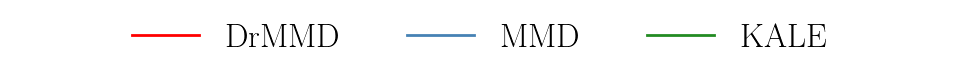

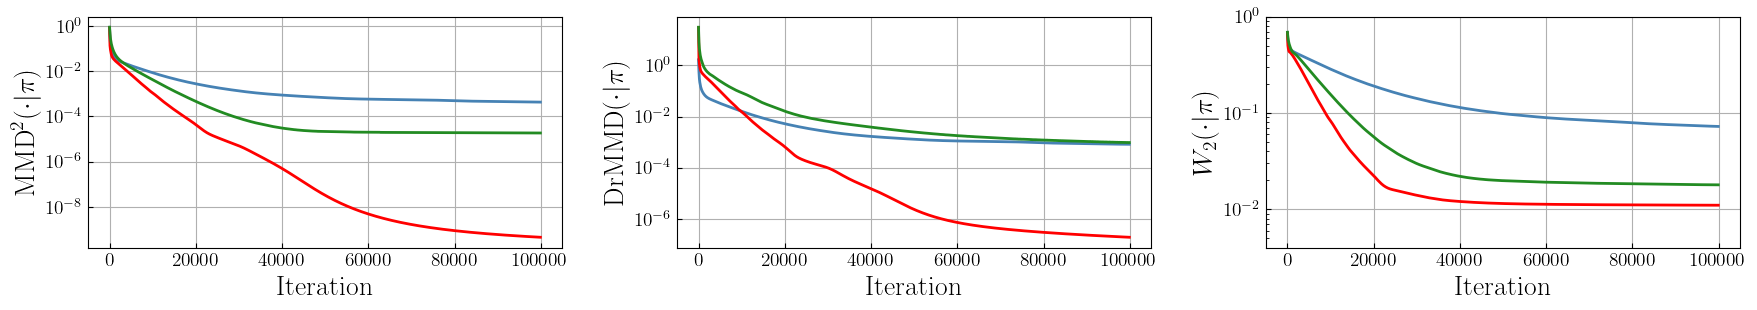

In [ ]:
legend_elements = [plt.Line2D([0], [0], color=color_dict['chard'], lw=2, label='DrMMD'),
                   plt.Line2D([0], [0], color=color_dict['mmd'], lw=2, label='MMD'),
                   plt.Line2D([0], [0], color=color_dict['kale'], lw=2, label='KALE'),
                   ]
x_ticks = jnp.arange(0, 100* T, 100)

# Create a new figure and axis for the legend
legend_fig, legend_ax = plt.subplots(figsize=(10, 1))
legend_ax.set_axis_off()
legend_ax.legend(handles=legend_elements, loc='center', ncol=4, fontsize='large')
plt.tight_layout()
plt.savefig(f'/home/zongchen/drmmd/figures/legend_three_ring.pdf')
 

fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))
for i, distance in enumerate(wasserstein_distance_all.keys()):
    axs[i].set_xlabel('Iteration')
    axs[i].set_ylabel(labels[distance])
    for method in wasserstein_distance_all[distance].keys():
        axs[i].plot(x_ticks, wasserstein_distance_all[distance][method], color=color_dict[method])
    if i == 2:
        axs[i].set_ylim([4e-3, 1.0])
    axs[i].set_yscale('log')
    # axs[i].legend()
plt.tight_layout()
plt.savefig(f'/home/zongchen/drmmd/figures/three_ring_mmd_chard_wass.pdf')
plt.show()

In [ ]:
x_ticks.shape

(1000,)

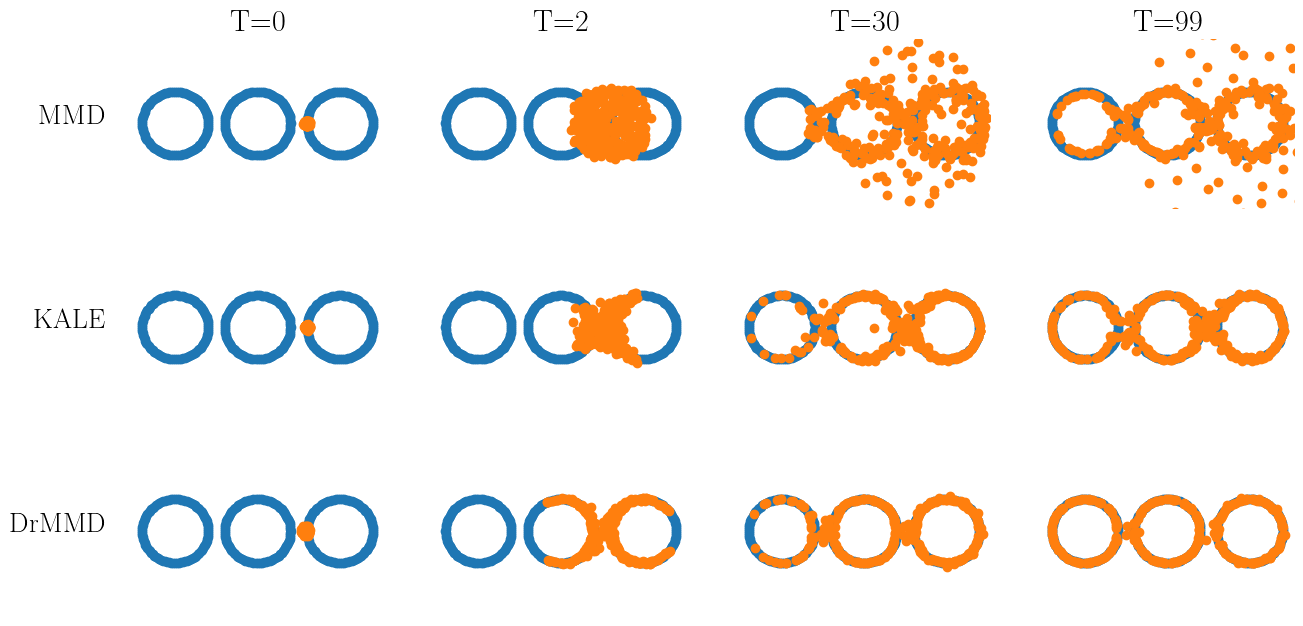

In [ ]:
f, axs = plt.subplots(nrows=3, ncols=4, figsize=(15, 7.5))
fancy_name = {'mmd': r'$\text{MMD}$',
              'chard': r'$\text{DrMMD}$',
              'kale': r'$\text{KALE}$'}
iters = [0, 2, 30, 99]
for axs_row, method in zip(axs, ('mmd', 'kale', 'chard')):
    axs_row[0].text(-0.1, 0.5, fancy_name[method], size=20, transform=axs_row[0].transAxes, horizontalalignment='right')
    for ax, iter_no in zip(axs_row, iters):
        if method == "mmd":
            ax.set_title(f'T={iter_no}')
            
        ax.set_xlim([-1.9, 0.4])
        ax.set_ylim([-0.8, 0.8])
        
        ax.scatter(target[:, 1], target[:, 0])
        ax.scatter(trajectorys[method][iter_no, :, 1], trajectorys[method][iter_no, :, 0])
        ax.axis('off')

plt.savefig(f'/home/zongchen/chard/figures/three_ring_animation.pdf')


In [ ]:

step_size_lmabda = {
                # 0.00001:1e-6,
                0.0001:  1e-5,
                0.0003:  3e-5,
                # 0.0006:  6e-5,
                0.001:  1e-4,
                0.003:  3e-4,
                0.006:  6e-4,
                0.01:  1e-3,
                # 0.1:  0.001,
                1.0: 0.001,
                10.0: 0.001,
                100.0: 0.001,
            }
lmbda_list = list(step_size_lmabda.keys())

chard_dir = '/home/zongchen/chard/results/ThreeRing_dataset/Gaussian_kernel/chard_flow/'
chard_hyper = ['bandwidth_0.15_',
               'step_num_100000_',
               'source_particle_num_300_',
               'inject_noise_scale_0.0_',
               'opt_sgd_']
chard_trajectory_lmbda = {lmbda: None for lmbda in lmbda_list}

for lmbda in lmbda_list:
    step_size = step_size_lmabda[lmbda]
    print(f"step_size = {step_size} for lambda = {lmbda}")  
    for file in os.listdir(chard_dir):
        if all(hyper in file for hyper in chard_hyper) and f'lmbda_{lmbda}_' in file:
            file_step_size = float(file.split('step_size_')[1].split('_')[0])
            print(file_step_size)
            if math.isclose(file_step_size, step_size, rel_tol=1e-9):
                chard_trajectory_lmbda[lmbda] = jnp.load(chard_dir + file + '/Ys.npy')
                                
    if chard_trajectory_lmbda[lmbda] is None:
        raise ValueError('No chard trajectory found at lmbda = {}'.format(lmbda))

mmd_dir = '/home/zongchen/chard/results/ThreeRing_dataset/Gaussian_kernel/mmd_flow/'
mmd_hyper = ['step_size_0.001_',
             'bandwidth_0.15_',
               'step_num_100000_',
               'source_particle_num_300_',
               'opt_sgd_']
mmd_trajectory = None
for file in os.listdir(mmd_dir):
    if all(hyper in file for hyper in mmd_hyper):
        mmd_trajectory = jnp.load(mmd_dir + file + '/Ys.npy')
        mmd_config = pickle.load(open(mmd_dir + file + '/configs', 'rb'))
        
if mmd_trajectory is None:
    raise ValueError('No mmd trajectory found')
chard_trajectory_lmbda['infinity'] = mmd_trajectory
lmbda_list += ['infinity']

step_size = 1e-05 for lambda = 0.0001
1e-05
1e-06
step_size = 3e-05 for lambda = 0.0003
3e-05
step_size = 0.0001 for lambda = 0.001
0.0001
1e-05
step_size = 0.0003 for lambda = 0.003
0.0003
step_size = 0.0006 for lambda = 0.006
0.0006
step_size = 0.001 for lambda = 0.01
0.0001
0.001
step_size = 0.001 for lambda = 1.0
0.01
0.1
0.001
step_size = 0.001 for lambda = 10.0
0.001
0.01
0.1
step_size = 0.001 for lambda = 100.0
0.01
0.001
0.1


In [ ]:
# wasserstein_distance_chard_lmbda = {lmbda: {'mmd': {}, 'chard': {}, 'wass': {}} for lmbda in lmbda_list}
wasserstein_distance_chard_lmbda = {lmbda: {'mmd': {}, 'wass': {}} for lmbda in lmbda_list}

for lmbda in lmbda_list:
    trajectory = chard_trajectory_lmbda[lmbda]
    T = trajectory.shape[0]
    particle_num = trajectory.shape[1]

    target, _ = generate_three_ring_and_gaussian(int(particle_num/3), particle_num)
    kernel = gaussian_kernel(configs[method]['bandwidth'])
    mmd, chard, wass = compute_all_distance_trajectory(configs[method], trajectory, target, kernel)
    wasserstein_distance_chard_lmbda[lmbda]['mmd'] = mmd
    # wasserstein_distance_chard_lmbda[lmbda]['chard'] = chard
    wasserstein_distance_chard_lmbda[lmbda]['wass'] = wass



In [ ]:
plt.rcParams['axes.grid'] = True
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.labelsize'] = 20
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath, amsfonts}')
plt.tight_layout()

plt.rc('font', size=20)
plt.rc('lines', linewidth=2)
plt.rc('legend', fontsize=18, frameon=False)
plt.rc('xtick', labelsize=14, direction='in')
plt.rc('ytick', labelsize=14, direction='in')
plt.rc('figure', figsize=(6, 4))


<Figure size 600x400 with 0 Axes>

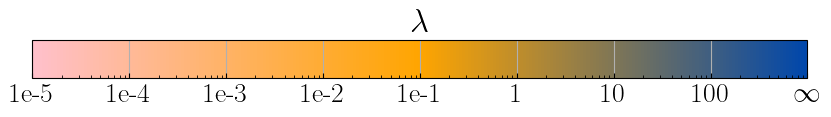

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Define the RGB values for your start and end colors

# Define the RGB values for red, orange, and green
# color_3 = np.array([255, 0, 0]) / 255   # Red
color_2 = np.array([255, 165, 0]) / 255   # Orange
# color_1 = np.array([0, 150, 0]) / 255   # Green
# color_3 = np.array([255, 192, 203]) / 255   # Green

# color_1 = np.array([135, 206, 235]) / 255   # Sky Blue
color_1 = np.array([255, 192, 203]) / 255  # Coral Pink
# color_1 = np.array([11, 102, 35]) / 255   # Lavender
color_3 = np.array([0, 71, 171]) / 255   # Green

# Create a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("custom_colormap", [color_1, color_2, color_3])

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 1))
fig.subplots_adjust(bottom=0.5)

# Create a LogNorm object for logarithmic normalization
norm = mcolors.LogNorm(vmin=1e-5, vmax=1000)

# Create a ScalarMappable and initialize a data array
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create a color bar
cb = plt.colorbar(sm, cax=ax, orientation='horizontal')

ticks = jnp.array([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000])
cb.ax.tick_params(labelsize=20)  # You can adjust the value '12' to your preferred font size
cb.set_ticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000])
ax.set_xlabel(r'$\lambda$', labelpad=-70, rotation=0, fontsize=24)

# Optionally, set custom tick labels
cb.set_ticklabels(['1e-5', '1e-4', '1e-3', '1e-2', '1e-1', '1', '10', '100', r'$\infty$'])
plt.savefig(f'/home/zongchen/chard/figures/colorbar_student_teacher.pdf')
plt.show()




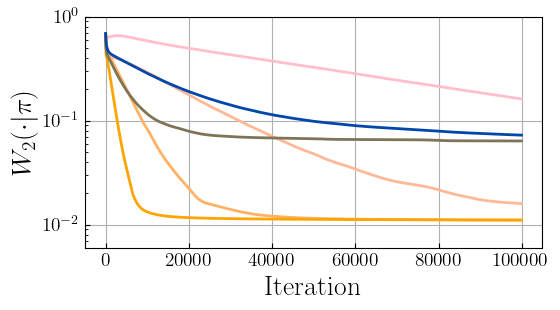

In [ ]:
lmbda_label = {
                # 0.00001:r'$\lambda = 10^{-5}$',
                0.0001: r'$\lambda = 10^{-5}$',
                0.0003: r'$\lambda = 10^{-4}$',
            #    0.0006: r'$\lambda = 6 \times 10^{-4}$',
               0.001: r'$\lambda = 10^{-3}$',
               0.003: r'$\lambda = 10^{-2}$',
            #    0.006: r'$\lambda = 6 \times 10^{-3}$',
                # 0.01: r'$\lambda = 10^{-2}$',
                # 0.1: r'$\lambda = 10^{-1}$',
                1.0: r'$\lambda = 10^{2}$',
                # 10.0: r'$\lambda = 10^{2}$',
                # 100.0: r'$\lambda = 10^{2}$',
                'infinity': r'$\lambda = \infty$'}
# set1 = plt.cm.get_cmap('Set1', 9) 
# lmbda_color_dict = {  
#     0.0001: set1(6) , # loosely dotted,
#     0.0003: 'black',
#     0.001: set1(2), #'loosely dashed',
#     0.003: set1(4),
#     1.0: 'pink', #'densely dashed',
#     # 10.0: 'pink', #'densely dashed',
#     'infinity': 'steelblue'
#             }


normalized_ticks = norm(ticks)
rgb_colors = cmap(normalized_ticks)[:,:3]

lmbda_color_dict = {  
    0.0001: rgb_colors[0],
    0.0003: rgb_colors[1],
    0.001: rgb_colors[2],
    0.003: rgb_colors[4],
    1.0: rgb_colors[6],
    'infinity': rgb_colors[8]
            }

line_dict = {
    0.0001: (0, (1, 5)), # loosely dotted,
    0.0003: 'dotted',
    0.001: (0, (5, 5)), #'loosely dashed',
    0.003: 'dashed',
    10.0: (0, (5, 1)), #'densely dashed',
    'infinity': 'solid'
            }
# # Function to interpolate between two colors
# def interpolate_color(color1, color2, factor: float):
#     return tuple(color1[i] * (1 - factor) + color2[i] * factor for i in range(3))

# # Red and blue RGB values
# color_start = (0.333, 0.686, 0.416) # RGB for light pink
# color_end = (0.980, 0.502, 0.447) # RGB for light blue

# # Generate evenly distributed colors
# num_colors = len(lmbda_label)
# colors = [interpolate_color(color_start, color_end, i / (num_colors - 1)) for i in range(num_colors)]

# # Create a color dictionary for each lambda value
# color_dict = {lmbda: color for lmbda, color in zip(list(lmbda_label.keys()), colors)}
# color_dict['infinity'] = 'steelblue'

fig, axs = plt.subplots(1, 1, figsize=(6, 3.5))
# plt.grid(False)
distance = 'wass'
for lmbda in lmbda_label.keys():
    axs.set_xlabel('Iteration')
    axs.set_ylabel(labels[distance])
    # axs[i].plot(x_ticks, wasserstein_distance_chard_lmbda[lmbda][distance], 
    #             label=lmbda_label[lmbda], linestyle = line_dict[lmbda], linewidth=1.5,
    #             color=color_dict['chard'])
    axs.plot(x_ticks, wasserstein_distance_chard_lmbda[lmbda][distance], 
                label=lmbda_label[lmbda], linewidth=2.0, color=lmbda_color_dict[lmbda])
    axs.set_yscale('log')
# axs[1].legend(ncol=1, loc='upper left', bbox_to_anchor=(1.0, 1.1))
axs.set_ylim([6e-3, 1.0])
plt.tight_layout()
plt.savefig(f'/home/zongchen/chard/figures/three_ring_lambda.pdf')
plt.show()

/tmp/ipykernel_966117/1728116287.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  set1 = plt.cm.get_cmap('Set1', 9)


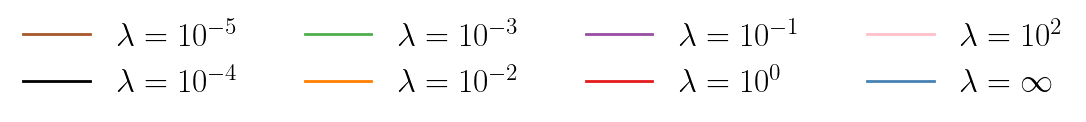

In [ ]:
legend_elements = []

lmbda_label = {0.00001: r'$\lambda = 10^{-5}$',
                0.0001: r'$\lambda = 10^{-4}$',
               0.001: r'$\lambda = 10^{-3}$',
                0.01: r'$\lambda = 10^{-2}$',
                0.1: r'$\lambda = 10^{-1}$',
                1.0: r'$\lambda = 10^{0}$',
                100.0: r'$\lambda = 10^{2}$',
                'infinity': r'$\lambda = \infty$'}
set1 = plt.cm.get_cmap('Set1', 9) 
lmbda_color_dict = {  
        0.00001: set1(6) ,
        0.0001: 'black',
        0.001: set1(2) ,
        0.01: set1(4) ,
        0.1: set1(3) ,
        1.0: set1(0) ,
        100.0: 'pink' ,
        'infinity': 'steelblue'
}
for lmdba in lmbda_label:
    legend_elements.append(plt.Line2D([0], [0], color=lmbda_color_dict[lmdba], lw=2, label=lmbda_label[lmdba]))

# Create a new figure and axis for the legend
legend_fig, legend_ax = plt.subplots(figsize=(12, 1))
legend_ax.set_axis_off()
legend_ax.legend(handles=legend_elements, loc='center', ncol=4, fontsize='large')
plt.tight_layout()
plt.savefig(f'/home/zongchen/chard/figures/legend_lambda.pdf')
 